<a href="https://colab.research.google.com/github/mostafa-ja/LLM_from_scratch/blob/main/Let's_build_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to build the model based on [karpathy's tutorial video ](https://www.youtube.com/watch?v=l8pRSuU81PU)

More explanation also [here](https://devshahs.medium.com/build-gpt-with-me-implementing-gpt-from-scratch-step-by-step-b2efe4e2f7e0), [here ](https://medium.com/@tusharmadaan/reproducing-gpt-2-124m-key-insights-and-techniques-cd8899864bbe) and [here ](https://towardsdatascience.com/line-by-line-lets-reproduce-gpt-2-section-1-b26684f98492/)

Tokenizer for GPT [here ](https://tiktokenizer.vercel.app/)




# Import data

In [ ]:
# Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-03-30 13:35:59--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2025-03-30 13:35:59 (16.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 200 characters
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


# BigramLanguageModel

Bigram language models are a fundamental statistical technique in NLP. They estimate the likelihood of a word appearing based solely on the word that came before it, essentially learning the probability distribution of word pairs in a text corpus. Although they capture local dependencies, bigrams are limited in handling long-range relationships, which are better addressed by models like trigrams, n-grams, or neural networks.



**Note:** In a Bigram Language Model, predictions are made based only on the immediately preceding character. Therefore, during training, the sequence length or block-size \( T \) could technically be set to 1 — we input a single character and predict the next one. However, in this implementation, we deliberately set \( T \) to a larger value. This is done to align with the architecture of transformer models, where attention mechanisms operate over sequences. Using a longer context prepares the model structure for scaling up to larger language models (LLMs), which rely heavily on longer sequences for capturing richer dependencies.


**Note2:** PyTorch’s internal layers (like Embedding, gather, etc.) are designed to work with 64-bit integers to ensure correctness and flexibility.so only accept indices of type **torch.long** (int64)

## encoding / decoding process

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:30]) # the 1000 characters we looked at earlier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43])


In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

### **Why Do We Reshape `logits` and `targets` in This Code?**  

The key reason for doing:  
```python
logits = logits.view(B*T, C)
targets = targets.view(B*T)
```
is to **reshape the tensors** in a way that is compatible with PyTorch’s `F.cross_entropy` function. Let's break it down step by step.

---

### **Understanding the Shape of `logits`**
1. **Before reshaping:**  
   ```python
   logits = self.token_embedding_table(idx)  # Shape: (B, T, C)
   ```
   - \( B \) = Batch size  
   - \( T \) = Sequence length  
   - \( C \) = Vocabulary size (since `nn.Embedding(vocab_size, vocab_size)` maps each token to a `vocab_size`-dimensional vector)

2. **Why reshape?**  
   - PyTorch’s `F.cross_entropy(logits, targets)` expects `logits` to have shape **`(N, C)`**
  - `targets` to have shape **`(N,)`**, where:
     - \( N \) is the number of training examples.
     - \( C \) is the number of classes (vocab size in this case).  
   
---

### **Final Reshaped Shapes**
| Variable | Original Shape | Reshaped Shape | Purpose |
|----------|---------------|---------------|---------|
| `logits` | `(B, T, C)` | `(B*T, C)` | Ensures each row represents a token prediction |
| `targets` | `(B, T)` | `(B*T,)` | Matches `logits` for loss computation |

---

### **Summary**
- The `view(B*T, C)` operation flattens the `(B, T, C)` logits so that each token prediction is treated as an independent classification problem.  
- The `view(B*T)` operation flattens the `(B, T)` targets into a single list of token indices for loss calculation.  
- This is necessary because PyTorch's `F.cross_entropy` requires `logits` to be of shape `(N, C)` and `targets` to be of shape `(N,)`.  



---


The function **torch.multinomial(probs, num_samples=1)** is used to randomly sample the next token from a probability distribution. This is a key part of generating text in language models.



In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # for generating new sequences of tokens, Given an initial input sequence idx
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C) # The shape becomes (B, C), where each row represents the logits for the next token prediction.
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Caveat: Why Do We Provide All Previous Tokens Instead of Just the Last One?**  

In the line:  
```python
logits = logits[:, -1, :]
```
we extract only the **last time step's logits** to generate the next token. This might seem inefficient because, technically, we only need the **last token** as input to predict the next one. So why do we provide the entire sequence as input instead of just the most recent token?

The key reason for this design choice is that in the Transformer model (unlike BigramLanguageModel), we don’t just rely on the previous token—we leverage **all previous tokens** using the **self-attention mechanism**.  

Thus, while it might seem like wasted computation **right now**, it's a design choice that aligns with how modern Transformer-based architectures work. 🚀

In [ ]:
torch.manual_seed(1337)
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
vocab_size = 65

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss) # in initial point the loss should be about -ln(1/65) ~ 4.17

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.6772, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


**Understanding `set_to_none=True` in `optimizer.zero_grad(set_to_none=True)`**

In PyTorch, when we perform backpropagation using `loss.backward()`, the gradients of the model’s parameters accumulate (i.e., they are **added** to existing values rather than being replaced). To prevent this accumulation, we need to reset the gradients before computing new ones. This is where `optimizer.zero_grad()` comes in.

---

**What Does `set_to_none=True` Do?**
```python
optimizer.zero_grad(set_to_none=True)
```
This line **resets** the gradients of all model parameters. The key behavior of `set_to_none=True` is:

1. **Instead of setting gradients to zero (`grad = 0`), it sets them to `None`.**
2. **This can reduce memory usage and improve performance.**



In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
for i in range(5000):
  xb, yb = get_batch('train')
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  if (i==0) or (i % 500 == 0):
    print(f"loss: {loss.item()}")




loss: 4.704006195068359
loss: 4.241008758544922
loss: 3.7031264305114746
loss: 3.4233598709106445
loss: 3.1371781826019287
loss: 2.9196817874908447
loss: 2.776794672012329
loss: 2.809856653213501
loss: 2.5844571590423584
loss: 2.6057393550872803


In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


Mavanghtang d wsramangT:
D: nd TINT:
Fof;AURKIfediTus, be:ghere
Dyo.O'd, t fed inks cerVis benes. ow


# Attention Mechanism

## Uniform Attention Mechanism

### Introduction
When processing a sequence of tokens, it is essential to consider the context provided by past tokens. The order in which tokens appear carries meaningful information. However, in a naive approach, each token is processed independently, meaning there is no interaction between them. Our goal is to allow each token to communicate selectively with past tokens while ensuring that future tokens remain inaccessible, as they are yet to be predicted.

### Input Representation
We define our input tensor as:

```
X.shape = (B, T, C) = (4, 8, 32)
```
where:
- **B** is the batch size,
- **T** is the number of tokens in the context window,
- **C** is the number of channels representing each token.

For instance, in a batch, we have **8 tokens**, each described by **32 channels**. Initially, these tokens do not interact with one another, meaning that the model processes them independently. Our objective is to enable communication among tokens while restricting each token’s access to **only previous tokens and itself** (causal attention). This ensures that we do not leak future information, which is crucial for autoregressive models.

### Naive Approach: Uniform Averaging
A simple way to incorporate past information is to take the average of all accessible past tokens. For example, if **t=5**, we could compute the average representation of tokens **1, 2, 3, 4, 5**. However, this approach is inefficient because it treats all past tokens **equally**, ignoring the varying degrees of relevance different tokens might have.

### Weighted Attention with a Masked Matrix
We introduce a **weight tensor** that assigns uniform importance levels to past tokens. The weight matrix is designed such that each token can only attend to past tokens and itself while ignoring future tokens.

#### Step 1: Creating the Masked Weight Matrix
We construct a **lower triangular matrix** that masks out future tokens:

```python
import torch
import torch.nn.functional as F

T = 8  # Number of tokens in the context window
tril = torch.tril(torch.ones(T, T))  # Lower triangular matrix

weight = torch.zeros((T, T))  # Initialize weights to zero
weight = weight.masked_fill(tril == 0, float('-inf'))  # Mask future tokens
weight = F.softmax(weight, dim=-1)  # Apply softmax to get probabilities
```

- The **lower triangular matrix** ensures that each token only considers past tokens.
- Applying **SoftMax** normalizes the values so that the sum of weights for each row equals **1**.
- Any masked positions (future tokens) are assigned **-inf**, which results in a softmax output of **zero**, effectively preventing any influence from future tokens.

#### Step 2: Applying the Attention Weights
Once we have the weight matrix, we apply it to our input tensor `X`:

```python
output = weight @ X  # (T, T) @ (B, T, C) --> (B, T, C)
```
This operation aggregates the past information for each token in a weighted manner.

### Example of the Weight Matrix (NOT uniform)
For **T=8**, an example of the computed weight matrix is:

```
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]])
```
- Each row corresponds to a token in the sequence.
- The sum of each row is **1**, ensuring that each token aggregates its past context without altering the total contribution.
- The **fifth row (t=5)**, for instance, distributes attention over tokens **1, 2, 3, 4, 5**.

### Summary
- The **attention mechanism** allows each token to selectively aggregate information from past tokens while ignoring future ones.
- A **triangular masking** approach ensures causality by preventing tokens from seeing future information.
- **SoftMax normalization** is used to distribute attention weights effectively.
- This weight matrix is the same across all samples in a batch since it depends only on the token positions within the context window.

This forms the basis for **self-attention mechanisms** used in modern deep learning architectures like **Transformers**.



In [ ]:
# consider the following toy example:
import torch
import torch.nn.functional as F

# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
print(wei)
out = wei @ x
print(out.shape)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
torch.Size([4, 8, 2])


## Understanding the Self-Attention Mechanism

Self-attention is a crucial component in Transformer models, allowing them to understand context by dynamically weighting the importance of different words in a sequence. Let's break it down step by step.

#### The Problem: Ambiguity in Word Meaning

Each word (token) in a sentence is initially represented as a vector, called an **embedding**, which captures its general meaning. However, words can have different meanings depending on context. For example, the word "model" could refer to an **AI model** or a **fashion model**. To resolve this ambiguity, we need a mechanism that considers surrounding words and extracts the correct meaning. This is where **self-attention** comes in—it enables each word to focus more on contextually relevant words.

### How Self-Attention Works
Self-attention operates using three key vectors derived from each token:
- **Query (Q)**: Represents what this word is looking for in others (e.g., a noun might look for its describing adjective).
- **Key (K)**: Represents what this word has to offer to others (e.g., an adjective offers descriptive details).
- **Value (V)**: Represents the actual content of the word (e.g., the actual meaning of the word).


These vectors are generated by multiplying the input embeddings with three learned weight matrices:

$$
Q = X \times W_q, \quad K = X \times W_k, \quad V = X \times W_v
$$

where:

- $X$ is the input word embeddings.
- $W_q, W_k, W_v$ are learned weight matrices that transform embeddings into their respective Q, K, and V vectors.

### Computing Attention Scores

The attention mechanism determines **how much each word should focus on others** in the sentence. This is done by computing a **similarity score** between the Query of one word and the Keys of all words:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) \times V
$$

- The dot product **$QK^T$** gives a similarity score between words.
- The result is scaled by $\sqrt{d_k}$ (where $d_k$ is the dimension of the key vector) to prevent large values from dominating.
- **Softmax** ensures that attention weights sum to 1, making them interpretable as probabilities.
- The attention scores determine how much of each value (V) contributes to the final representation.



### Example

Let’s break down the sentence **"The cat sat on the mat"** and provide realistic representations for **Attention Weights** and **Value (V)** vectors in the context of self-attention. I’ll also explain the role of each word and how they might interact. Since we’re simulating a Transformer-like model, I’ll make some reasonable assumptions about embeddings and attention behavior, keeping it intuitive yet grounded in how such models typically work.

### Setup and Assumptions
- **Sentence:** "The cat sat on the mat" (6 tokens, including a period for simplicity).
- **Vector Size:** Let’s assume 4-dimensional vectors for Q, K, and V (in reality, they’re often 64 or 512 dims, but 4 keeps it manageable).
- **Process:** Each word gets Q, K, and V vectors. Attention weights come from Q and K interactions, and V vectors are combined using those weights.
- **Goal:** Show how V contributes to the output and interpret each word’s role.

I’ll assign plausible V vectors based on linguistic roles (e.g., nouns, verbs, articles) and estimate attention weights based on likely dependencies in this simple sentence.

---

### Step 1: Define Roles of Each Word
Before diving into numbers, let’s understand what each word does:
1. **"The" (determiner):** Specifies the noun "cat." It’s a helper, pointing to something definite.
2. **"cat" (noun, subject):** The main actor, the entity doing the sitting.
3. **"sat" (verb):** The action, central to the sentence, linking "cat" to its location.
4. **"on" (preposition):** Indicates position, connecting "sat" to "mat."
5. **"the" (determiner):** Specifies "mat," another helper for the object.
6. **"mat" (noun, object):** The location or recipient of the action.

In self-attention, each word looks at all others to build context. For example, "cat" might focus on "sat" (its action) and "The" (its specifier), while "sat" might focus on "cat" (subject) and "on" (where it happened).

---

### Step 2: Assign Plausible Value (V) Vectors
These are hypothetical but inspired by how embeddings capture meaning (e.g., nouns might emphasize entity features, verbs action features), consider that V calculates based on input X and learned weights Wv. Let’s use a 4D vector where dimensions loosely represent:
- [entity, action, relation, modifier] (just for intuition, not strict).

- **"The" (first):** V = [0.5, 0.0, 0.2, 0.3]  
  - Mild entity boost (specifies something), some relation/modifier role.
- **"cat":** V = [1.0, 0.1, 0.2, 0.0]  
  - Strong entity (noun), tiny action/relation hint.
- **"sat":** V = [0.2, 1.0, 0.3, 0.0]  
  - Strong action (verb), some entity/relation from subject and object.
- **"on":** V = [0.1, 0.2, 1.0, 0.1]  
  - Strong relation (preposition), minor entity/action.
- **"the" (second):** V = [0.5, 0.0, 0.2, 0.3]  
  - Same as first "The," specifying "mat."
- **"mat":** V = [1.0, 0.1, 0.3, 0.0]  
  - Strong entity (noun), slight relation hint (it’s the object).

These V vectors are the "content" each word offers—its semantic contribution.

---

### Step 3: Estimate Attention Weights
Attention weights come from $$\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
$$ also Q and K calculated based on input X learned wights of Wq and Wk. We’ll estimate weights based on linguistic intuition. Each row sums to 1.0, representing how much each word attends to others.

| **Query Word** | **The1** | **cat** | **sat** | **on** | **the2** | **mat** |
|----------------|----------|---------|---------|--------|----------|---------|
| **The1**       | 0.40     | 0.40    | 0.10    | 0.05   | 0.03     | 0.02    |
| **cat**        | 0.30     | 0.20    | 0.40    | 0.05   | 0.03     | 0.02    |
| **sat**        | 0.05     | 0.35    | 0.25    | 0.25   | 0.05     | 0.05    |
| **on**         | 0.02     | 0.05    | 0.35    | 0.20   | 0.15     | 0.23    |
| **the2**       | 0.03     | 0.02    | 0.05    | 0.15   | 0.35     | 0.40    |
| **mat**        | 0.02     | 0.05    | 0.10    | 0.25   | 0.30     | 0.28    |

#### Interpretation of Weights:
- **"The1":** Focuses on itself (0.40) and "cat" (0.40), as it specifies the subject.
- **"cat":** Attends to "sat" (0.40) for its action and "The1" (0.30) for specificity.
- **"sat":** Balances "cat" (0.35, subject), itself (0.25), and "on" (0.25, location).
- **"on":** Looks at "sat" (0.35, the action it modifies) and "mat" (0.23, its object).
- **"the2":** Focuses on "mat" (0.40) and itself (0.35), specifying the object.
- **"mat":** Attends to "on" (0.25, its position) and "the2" (0.30, its specifier).

These weights reflect dependency-like relationships, close to what a trained model might learn.

---

### Step 4: Compute Output for One Word (Example: "cat")
Using the attention weights for "cat" and the V vectors:
- Weights: [0.30, 0.20, 0.40, 0.05, 0.03, 0.02]
- V vectors: From above.

Output = Σ (weight × V):
- 0.30 × [0.5, 0.0, 0.2, 0.3] = [0.15, 0.0, 0.06, 0.09] (The1)
- 0.20 × [1.0, 0.1, 0.2, 0.0] = [0.20, 0.02, 0.04, 0.0] (cat)
- 0.40 × [0.2, 1.0, 0.3, 0.0] = [0.08, 0.40, 0.12, 0.0] (sat)
- 0.05 × [0.1, 0.2, 1.0, 0.1] = [0.005, 0.01, 0.05, 0.005] (on)
- 0.03 × [0.5, 0.0, 0.2, 0.3] = [0.015, 0.0, 0.006, 0.009] (the2)
- 0.02 × [1.0, 0.1, 0.3, 0.0] = [0.02, 0.002, 0.006, 0.0] (mat)

Sum = [0.47, 0.432, 0.292, 0.104]

**New "cat" representation:** [0.47, 0.432, 0.292, 0.104]
- Stronger entity (0.47) and action (0.432) from "cat" and "sat," with some relation (0.292) from "on."

---

### Step 5: Role of Each Word via V and Attention
- **"The1":** Its V ([0.5, 0.0, 0.2, 0.3]) gives "cat" specificity (entity + modifier). Attention to "cat" (0.40) reinforces this.
- **"cat":** Its V ([1.0, 0.1, 0.2, 0.0]) is the subject’s core. It pulls action from "sat" (0.40 weight).
- **"sat":** Its V ([0.2, 1.0, 0.3, 0.0]) is the action hub, shared with "cat" and "on," shaping the event.
- **"on":** Its V ([0.1, 0.2, 1.0, 0.1]) links "sat" to "mat," adding relational context.
- **"the2":** Its V ([0.5, 0.0, 0.2, 0.3]) specifies "mat," aiding the object’s clarity.
- **"mat":** Its V ([1.0, 0.1, 0.3, 0.0]) is the object, enriched by "on" and "the2."

---

### Reality Check
In a real Transformer:
- Vectors would be higher-dimensional (e.g., 512), capturing nuanced features.
- Attention weights would come from trained Q-K dot products, not intuition.
- Multi-head attention would split focus across different aspects (e.g., syntax vs. semantics).

Still, this approximation mirrors how V carries meaning (e.g., action from "sat") and attention weights prioritize relationships (e.g., "cat" to "sat").

---

### Closing
The V vectors are the "what" each word contributes—its semantic essence—while attention weights decide "how much" of each V matters. For "cat," the output blends its identity with its action ("sat"), tuned by helpers like "The" and "on." Does this bring it closer to reality for you? Want to tweak something or explore another word’s output? Let me know!

## Self-attention


### **Attention Layer in GPT-2**  

GPT-2 employs a **causal self-attention mechanism**, which ensures that each token in the sequence can only attend to the tokens that precede it. This is what makes the model "causal"—it prevents information from leaking from future tokens, thereby maintaining the autoregressive nature of the model, which is crucial for generating coherent text.  

At a high level, this attention mechanism can be viewed as a **message-passing process** on a graph, where each token is treated as a node. As the model processes a sequence, it **updates each token’s representation (embedding) by aggregating relevant information from previous tokens**. This is accomplished using **key, query, and value vectors**:  

- **Query**: Represents the token making the request for information.  
- **Key**: Represents the token providing information.  
- **Value**: The actual information that is shared between tokens.  

Each token compares its query with the keys of all preceding tokens to determine how much attention it should pay to them. The resulting weighted sum of values updates the token’s embedding, allowing it to incorporate contextual information dynamically.  

#### **Multi-Head Attention**  
GPT-2 employs **multiple attention heads**, each initialized differently on different subspaces of the input embedding. This design allows different heads to **capture distinct aspects of relationships between tokens**:  
- Some heads may specialize in **syntactic dependencies**, helping the model understand grammatical structures.  
- Other heads may focus on **semantic relationships**, enabling a better grasp of meaning across words.  

By processing multiple attention heads in parallel, the model **enhances its understanding of long-range dependencies and improves contextual coherence** across sequences. This multi-headed structure contributes significantly to GPT-2’s ability to generate fluent and contextually relevant text.  



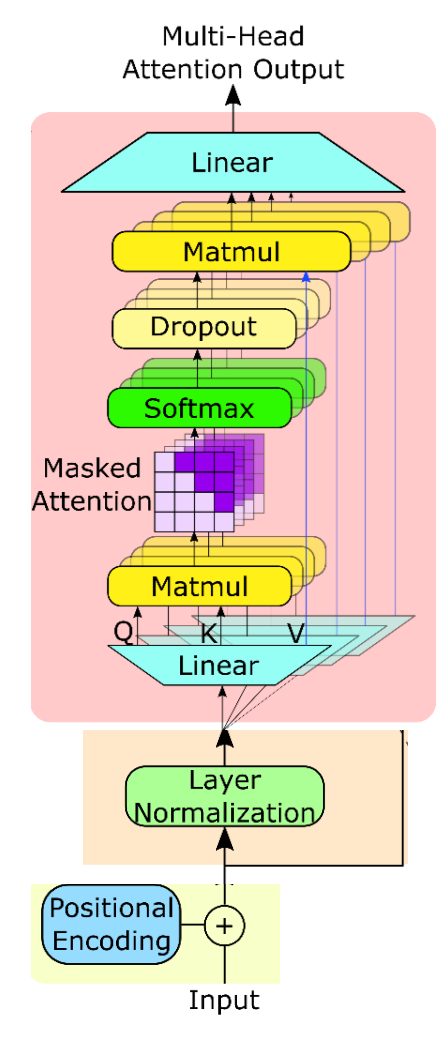

In [ ]:
# self-attention (a single Head)
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16  # it takes 32 channels information for a token and gives 16 channels info for just a specific head
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

Each linear layer (nn.Linear) transforms the input tensor from the original channel size (C) to a specified head_size without bias. We do this because we want to project the original input tensor x, with dimensions (B, T, C), into three separate spaces—keys (k), queries (q), and values (v)—each with a reduced dimensionality specified by the hyperparameter head_size.

**Why We Don’t Use Bias in Self-Attention**
*   Each linear layer in self-attention serves only as a projection from input features (C) to the head_size dimension. Unlike activation functions (like ReLU), where bias can help with shifting the output, the self-attention mechanism does not require a bias shift
*   Self-attention works on relative importance, making absolute shifts (caused by bias) irrelevant.




**Notes:**
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space (awareness of position of the token in the context). Attention simply acts over a set of vectors. This is why we need to positionally encode tokens (which is added to inouts).
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling (attention paper has both encoder and decoder and designed for translation not language model).
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

### **What is Scaled Attention?**  

In Transformer-based models like GPT-2, attention mechanisms compute scores to determine how much focus each token should place on others in the sequence. However, if these scores become too large, they can lead to issues such as **vanishing or exploding gradients**, which can slow down learning or make optimization unstable.  

To address this, Transformers use **scaled attention**, a technique that involves dividing the computed attention scores by the square root of the dimensionality of the key vectors.  

#### **Why Scaling?**  
The raw attention scores are computed as follows:  

$$
\text{Attention Score} = \frac{QK^T}{\sqrt{d_k}}
$$

where:  
- $( Q )$ (Query) represents the current token’s vector.  
- $( K )$ (Key) represents the vectors of the tokens being attended to.  
- $( d_k )$ is the dimensionality of the key vectors.  
-
$( QK^T )$ computes dot products between queries and keys, determining how similar they are.  

Since the dot product grows with the size of $( d_k )$, larger values could cause the **softmax function** to produce extremely sharp probability distributions. This leads to:  
- **Small gradients**, making it hard for the model to learn effectively.  
- **Attention scores dominated by a few large values**, reducing the model’s ability to distribute attention properly.  

To counteract this, we **divide by $( \sqrt{d_k} )$** to normalize the scores. This **prevents extreme values, stabilizes training, and ensures better gradient flow**.

#### **Effect of Scaling**  
- **Without scaling:** The softmax function would produce very peaked distributions, where a few tokens dominate attention.  
- **With scaling:** The scores remain balanced, ensuring a more **even spread of attention** across relevant tokens. **specially at initialization step**  

This simple yet crucial adjustment makes Transformers like GPT-2 more **stable and efficient** during training, leading to better performance on large-scale language modeling tasks.



**Mathematical Explanation:**

* Let $q$ and $k$ be vectors of dimension $d_k$, where each element is drawn from a distribution with mean 0 and variance 1.
* The dot product $q \cdot k = \sum_{i=1}^{d_k} q_i k_i$.
* The variance of the dot product is:
    * $Var(q \cdot k) = Var(\sum_{i=1}^{d_k} q_i k_i) = \sum_{i=1}^{d_k} Var(q_i k_i)$.
    * Assuming $q_i$ and $k_i$ are independent, $Var(q_i k_i) = Var(q_i) Var(k_i) = 1 \cdot 1 = 1$.
    * Therefore, $Var(q \cdot k) = \sum_{i=1}^{d_k} 1 = d_k$.
* When we divide by $\sqrt{d_k}$, the variance becomes:
    * $Var(\frac{q \cdot k}{\sqrt{d_k}}) = \frac{1}{d_k} Var(q \cdot k) = \frac{1}{d_k} d_k = 1$.

**In summary:**

Dividing by $\sqrt{d_k}$ ensures that the variance of the dot product remains constant, preventing the softmax function from producing extremely peaked distributions and thus stabilizing the gradients during training. This leads to more effective learning and better model performance.


In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

print(k.var())
print(q.var())
print(wei.var())

tensor(1.0449)
tensor(1.0700)
tensor(1.0918)


In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*0.01, dim=-1) # converges to a uniform vector

tensor([0.2000, 0.1994, 0.2004, 0.1994, 0.2008])

**Layer Normalization (Pre-norm) in GPT-2: Stabilizing Deep Transformer Training**

GPT-2 deviates from the original Transformer architecture by employing "pre-normalization" instead of "post-normalization." This seemingly subtle shift has a significant impact on training stability and gradient flow, especially in deep Transformer models.

**Traditional Transformer (Post-norm):**

* In the original Transformer, Layer Normalization (LayerNorm) is applied *after* each sub-layer (multi-head attention and feed-forward network).
* This is known as "post-normalization."
* While effective, post-norm can sometimes lead to instability during training, particularly in very deep models.

**GPT-2's Pre-norm Approach:**

* GPT-2, and many subsequent Transformer variants, adopt "pre-normalization."
* This means LayerNorm is applied to the *input* of each sub-layer, rather than the output.
* Specifically, the input to the Multi-Head Attention and the Feed Forward network is normalized before it is processed.

**Benefits of Pre-norm:**

1.  **Improved Gradient Flow:**
    * Pre-norm helps to keep the activations within a more consistent range throughout the network.
    * By normalizing the input, we prevent the activations from becoming excessively large or small, which can lead to exploding or vanishing gradients, respectively.
    * This results in smoother and more stable gradient flow during backpropagation, facilitating more effective training.

2.  **Enhanced Training Stability:**
    * Deep Transformer models are notoriously challenging to train. Pre-norm significantly improves stability, allowing for the training of deeper and larger models.
    * The normalization step prevents the propagation of extreme values through the network, which can disrupt the learning process.


**Analogy:**

* Think of it like preparing the "canvas" (input) before applying "paint" (sub-layers). By ensuring the canvas is consistently smooth and prepared, the painting process becomes more stable and predictable.

**Reference:**

* The "Transformers without Tears" paper provides a more in-depth analysis of the benefits of pre-normalization.




## 🔄 BatchNorm vs. LayerNorm in GPT

### 🔸 **Batch Normalization (BatchNorm)**

- **Normalizes across the batch dimension**:
  - For each feature, the mean and variance are computed across all samples in the batch.
- **Sensitive to batch size**:
  - Works best with large batches. Small batches can cause unstable training.
- **Commonly used in** CNNs and MLPs.

**Formula (for input shape `[batch_size, features]`):**

$$
\mu = \frac{1}{B} \sum_{i=1}^{B} x_i, \quad
\sigma^2 = \frac{1}{B} \sum_{i=1}^{B} (x_i - \mu)^2
$$

---

### 🔹 **Layer Normalization (LayerNorm)** — *Used in GPT*

- **Normalizes across the feature dimension**:
  - Each sample or token is normalized using only its own features.
- **Independent of batch size**:
  - Works even with batch size = 1.
- **Well-suited for** transformers and language models.

**Formula (for input shape `[features]` per token):**

$$
\mu = \frac{1}{d} \sum_{j=1}^{d} x_j, \quad
\sigma^2 = \frac{1}{d} \sum_{j=1}^{d} (x_j - \mu)^2
$$

---

## 🔍 Why GPT Uses LayerNorm Instead of BatchNorm

### 🔸 1. Normalization Scope
- BatchNorm: Uses statistics across the batch.
- LayerNorm: Uses statistics within each token.

✅ *Each token in a sequence is processed independently.*

---

### 🔸 2. Sensitivity to Batch Size
- BatchNorm: Unstable with small batches.
- LayerNorm: Independent of batch size.

✅ *GPT works well even with batch size = 1 during inference.*

---

### 🔸 3. Variable-Length Sequences
- BatchNorm: Assumes fixed-sized input.
- LayerNorm: Handles varying sequence lengths naturally.

✅ *Ideal for NLP where input lengths vary.*

---

### 🔸 4. Transformer Compatibility
- BatchNorm: Best for CNNs.
- LayerNorm: Ideal for transformer layers with attention and MLPs.

✅ *LayerNorm integrates seamlessly into GPT architecture.*

---

## ✅ Summary Table

| Feature                     | **BatchNorm**                 | **LayerNorm (used in GPT)**     |
|-----------------------------|-------------------------------|----------------------------------|
| Normalizes over             | Batch                         | Features                         |
| Affected by batch size?     | ✅ Yes                         | ❌ No                             |
| Works with variable length? | ❌ No                          | ✅ Yes                            |
| Autoregressive compatible?  | ❌ No                          | ✅ Yes                            |
| Commonly used in            | CNNs, MLPs                    | Transformers, GPT, BERT          |

---

## 🔚 Conclusion

**LayerNorm is preferred in GPT** because it works with:
- Small or variable batch sizes
- Variable-length sequences
- Autoregressive token-by-token generation  
- Transformer architectures that rely on attention over embeddings



In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

# Building the model

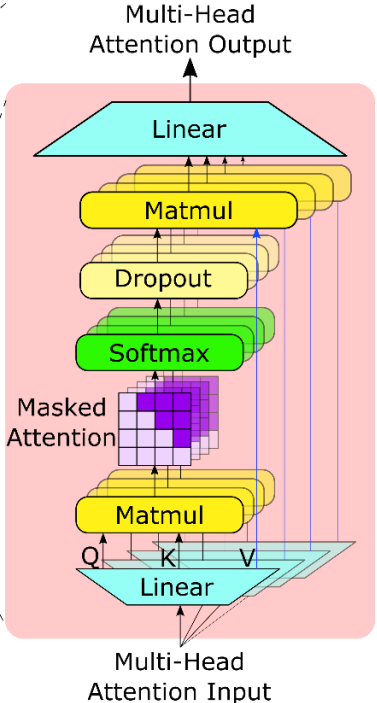

Let's break down the line `self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))` within the context of the provided `Head` class.


1.  
 **`self.register_buffer('tril', ...)`:**
    * `self.register_buffer()` is a PyTorch `nn.Module` method used to register a tensor as a buffer.
    * A buffer is a tensor that is not considered a model parameter. This means:
        * It is not updated by the optimizer during training (its values are not learned).
        * It is saved as part of the model's state dictionary.
        * It will be moved to the correct device when you use .to("cuda") or .to("cpu").
    * In this case, the lower triangular matrix is being registered as a buffer named `'tril'`.


**Why Use a Buffer?**

* The `tril` matrix is a constant mask that does not need to be learned.
* Using `register_buffer()` ensures that it is properly handled by the model's state and moved to the correct device, without being treated as a trainable parameter.
* This is more efficient than recreating the tril matrix every time the forward function is called.



**Why** ``` self.tril[:T, :T] ``` ?

The code is written in a way that handles the general case when T is less than or equal to block_size(for example at the end of content). This makes the code more robust, as it will work correctly even if the length of the input sequence varies.




In [ ]:
block_size = 32
n_embd = 64
n_head = 4
dropout = 0.2

class Head(nn.Module):
    """ One head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

        # Causal mask to prevent attending to future tokens
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, _ = x.shape

        # Linear projections: (B, T, head_size)
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        # Compute scaled dot-product attention scores: (B, T, T)
        # ATTENTION: This is the only step that tokens interact with each other
        attn_scores = (q @ k.transpose(-2, -1)) / k.shape[-1]**0.5
        attn_scores = attn_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention weights to values: (B, T, head_size)
        out = attn_weights @ v
        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Multiple self-attention heads run in parallel, followed by a linear projection """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)  # Final projection layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Concatenate outputs from all attention heads: (B, T, n_embd)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # Final linear projection and dropout
        out = self.dropout(self.proj(out))
        return out

### Multi Head Attention:

* `num_heads * head_size` must equal `n_embd` — ensure this when calling it.
* Uses `torch.cat([...], dim=-1)` to join all head outputs along the feature dimension.
* Applies a final linear projection (`proj`) to mix information from different heads.
* Includes a dropout layer after projection, just like the original Transformer design.

### 🔧 In Your Code:

```python
self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
```

This means:

* You're creating a list of `num_heads` attention heads.
* Each one is an instance of your `Head` class, initialized with `head_size`.
* `nn.ModuleList([...])` wraps this list so that PyTorch knows to **treat each head as part of the model**.

Without `nn.ModuleList`, PyTorch wouldn't recognize the layers, and things like model saving, `.cuda()`, or `.parameters()` wouldn't work properly.

---

### ✅ Why Not Just Use a Regular List?

If you did:

```python
self.heads = [Head(head_size) for _ in range(num_heads)]
```

Then:

* The modules wouldn't be registered.
* The model wouldn’t track them for backpropagation, saving, or device moves.
* You'd break things like `model.to(device)` or `optimizer = torch.optim.Adam(model.parameters())`.


### 🔍 **Why GPT Handles Inputs Shorter Than `block_size` Without Issues**

GPT-style models are designed to flexibly handle input sequences of any length up to a maximum context window, defined by `block_size`. When your input is shorter than this limit, the model still functions seamlessly — **no padding or filler tokens are needed**.

Let’s unpack why this works:

---

### 📏 **1. Computation Scales with the Actual Sequence Length (`T`)**

Although `block_size` defines the maximum sequence length, the model dynamically operates on the **actual input length**, denoted as `T`.

* Core components such as embedding lookups, self-attention, and feedforward networks are all computed over just the `T` tokens you provide.
* For instance, if `block_size = 32` but your input has only 10 tokens, the model performs computations on just those 10 — there's no need to pad up to 32.

✅ This ensures **no wasted computation**, making the model both efficient and adaptable.

---

### 🧱 **2. Embeddings and Token-Level Operations Are Fully Parallel**

Each token in the input sequence is processed independently through the following steps:

* **Token embedding**: Maps each token to a dense vector.
* **Position embedding**: Adds positional context by assigning each token a unique positional vector.

After embedding, each token flows through:

* Multi-Layer Perceptrons (MLPs)
* Layer Normalization
* Residual Connections

✅ These operations are **fully parallelized** across tokens, meaning the model processes the entire sequence simultaneously — regardless of whether it’s 5 tokens or 50.

---

### 🔄 **3. Self-Attention Enables Contextual Interactions**

The only component where tokens interact is the **self-attention mechanism**:

* Each token calculates attention scores relative to **all earlier tokens** in the sequence.
* A **causal attention mask** (lower triangular matrix) ensures that tokens can’t "look ahead" to future tokens.

This is typically implemented as:

```python
tril[:T, :T]
```

where `T` is the actual input length.

✅ The mask dynamically adjusts to the sequence size, ensuring proper attention behavior even for very short inputs.

---

### ✅ **In Summary**

GPT models handle inputs shorter than `block_size` effortlessly because:

1. All computations adapt to the real input length `T`.
2. Embedding and token-wise processing are fully parallel.
3. Self-attention uses a flexible mask that scales with the input.

This architecture makes GPT both **scalable** and **efficient** for sequences of any length within its context window.


### Multi-layer perceptron

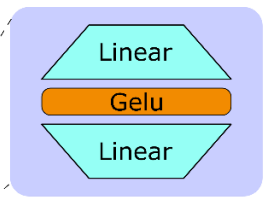

The `FeedFoward` class, representing a multi-layer perceptron (MLP) within a self-attention block (like in a Transformer), serves a crucial purpose: **to introduce non-linearity and enhance the model's ability to learn complex relationships within the data.**

1.
    * Without non-linearity, the model would be limited to learning linear combinations of the input, which is insufficient for capturing the intricate patterns present in most real-world data.

    * The feedforward network operates on each position (each token) in the input sequence independently.
    * It takes the output of the self-attention mechanism, which contains contextual information from other positions, and further refines it.
    * This allows the model to process the context-aware representations and extract more meaningful features.



In [ ]:
# Multi-layer perceptron

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

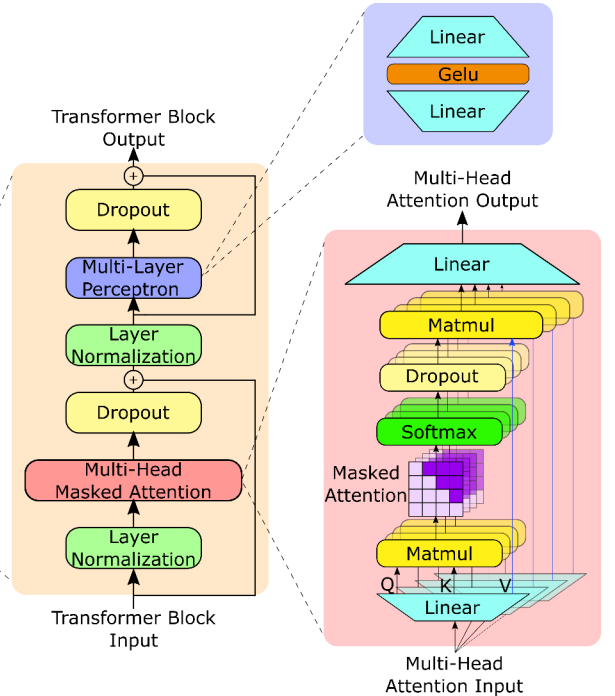

### Transformer block

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


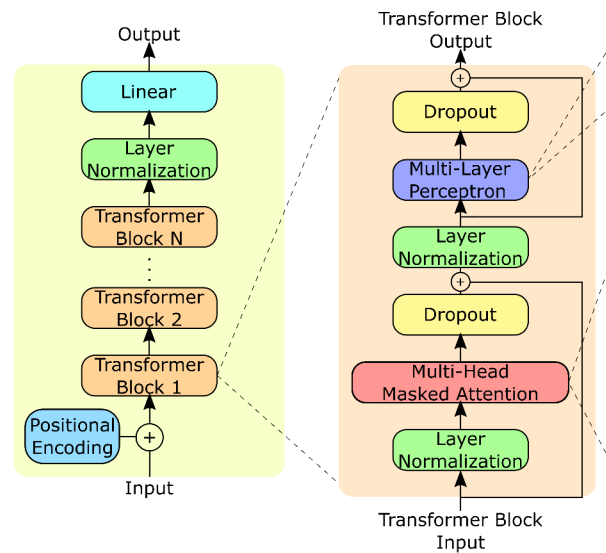

In [ ]:


# super simple GPT model
class GPT(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# New Section

In [ ]:
import sentencepiece as spm

# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="input.txt",
  input_format="text",
  # output spec
  model_prefix="tok512", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=512,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=False,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)


In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('tok512.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
print(vocab)

[['<unk>', 0], ['<s>', 1], ['</s>', 2], ['▁t', 3], ['he', 4], ['▁a', 5], ['ou', 6], ['▁s', 7], ['▁m', 8], ['▁w', 9], ['in', 10], ['re', 11], ['ha', 12], ['▁the', 13], ['nd', 14], ['▁b', 15], ['is', 16], ['or', 17], ['▁f', 18], ['▁I', 19], ['er', 20], ['ll', 21], ['it', 22], ['on', 23], ['▁d', 24], ['▁c', 25], ['▁n', 26], ['▁l', 27], ['▁y', 28], ['es', 29], ['en', 30], ['▁th', 31], ['ar', 32], ['▁h', 33], ['▁o', 34], ['▁to', 35], ['▁you', 36], ['▁p', 37], ['▁T', 38], ['hat', 39], ['▁A', 40], ['▁he', 41], ['st', 42], ['ve', 43], ['ot', 44], ['▁and', 45], ['ow', 46], ['ing', 47], ['▁of', 48], ['an', 49], ['om', 50], ['▁g', 51], ['at', 52], ['▁be', 53], ['▁W', 54], ['se', 55], ['▁my', 56], ['▁in', 57], ['▁ha', 58], ['ce', 59], ['le', 60], ['ay', 61], ['ld', 62], ['ir', 63], ['et', 64], ['ed', 65], ['ut', 66], ['▁B', 67], ['▁me', 68], ['im', 69], ['▁S', 70], ['ith', 71], ['▁not', 72], ['▁H', 73], ['ch', 74], ['▁that', 75], ['▁is', 76], ['▁M', 77], ['gh', 78], ['▁And', 79], ['▁for', 80], ['▁

In [ ]:
import sentencepiece as spm

# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="lower_input.txt",
  input_format="text",
  # output spec
  model_prefix="tok512_lower", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=512,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=False,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)

In [ ]:
sp_lower = spm.SentencePieceProcessor()
sp_lower.load('tok512_lower.model')
vocab_lower = [[sp_lower.id_to_piece(idx), idx] for idx in range(sp_lower.get_piece_size())]
print(vocab_lower)

[['<unk>', 0], ['<s>', 1], ['</s>', 2], ['▁t', 3], ['he', 4], ['▁a', 5], ['▁s', 6], ['▁w', 7], ['▁i', 8], ['ou', 9], ['▁m', 10], ['▁b', 11], ['ha', 12], ['re', 13], ['▁the', 14], ['nd', 15], ['in', 16], ['or', 17], ['▁f', 18], ['▁c', 19], ['▁o', 20], ['er', 21], ['▁l', 22], ['ll', 23], ['▁d', 24], ['▁n', 25], ['hi', 26], ['▁y', 27], ['en', 28], ['▁p', 29], ['st', 30], ['▁to', 31], ['▁and', 32], ['ar', 33], ['▁you', 34], ['▁he', 35], ['on', 36], ['▁g', 37], ['th', 38], ['es', 39], ['ing', 40], ['▁th', 41], ['▁of', 42], ['▁no', 43], ['hat', 44], ['an', 45], ['ve', 46], ['om', 47], ['▁wi', 48], ['▁be', 49], ['▁ha', 50], ['se', 51], ['▁my', 52], ['ce', 53], ['▁hi', 54], ['ow', 55], ['▁in', 56], ['at', 57], ['le', 58], ['▁that', 59], ['ri', 60], ['ed', 61], ['ay', 62], ['et', 63], ['▁for', 64], ['ut', 65], ['▁k', 66], ['ld', 67], ['▁is', 68], ['▁we', 69], ['ir', 70], ['us', 71], ['▁me', 72], ['▁e', 73], ['▁h', 74], ['ke', 75], ['▁not', 76], ['▁with', 77], ['ch', 78], ['gh', 79], ['oo', 80],

In [ ]:
input = "you are all resolved rather to die than to famish? before we proceed any further, hear me speak."
ids = sp.encode(input)
ids_lower = sp_lower.encode(input)

print(len(input))

print(len(ids))
print([sp.id_to_piece(idx) for idx in ids])

print(len(ids_lower))
print([sp_lower.id_to_piece(idx) for idx in ids_lower])

96
36
['▁you', '▁are', '▁all', '▁re', 's', 'ol', 've', 'd', '▁r', 'ather', '▁to', '▁d', 'ie', '▁than', '▁to', '▁f', 'am', 'ish', '?', '▁be', 'fore', '▁we', '▁pro', 'ce', 'ed', '▁an', 'y', '▁f', 'ur', 't', 'her', ',', '▁hear', '▁me', '▁speak', '.']
35
['▁you', '▁are', '▁all', '▁re', 's', 'ol', 've', 'd', '▁r', 'ather', '▁to', '▁d', 'ie', '▁than', '▁to', '▁f', 'am', 'ish', '?', '▁be', 'fore', '▁we', '▁pro', 'ce', 'ed', '▁an', 'y', '▁f', 'ur', 'ther', ',', '▁hear', '▁me', '▁speak', '.']


# Background

### **Understanding `nn.Embedding` in Transformers**  

The `nn.Embedding` layer in Transformer models is a crucial component that converts discrete token indices into dense, continuous vector representations. It functions similarly to a **fully connected layer** but is structured as a **lookup table** rather than performing explicit matrix multiplications.

---

### **Concept of `nn.Embedding`**
The embedding layer is mathematically equivalent to a fully connected (linear) layer where:  

- The **input size** is the **vocabulary size** (\(V\)).  
- The **output size** is the **embedding dimension** (\(d\)).  
- The **weight matrix** of this layer acts as a lookup table.  

Instead of performing matrix multiplication, the input token (represented as an integer index) selects the corresponding row from the weight matrix.

### **How It’s Similar to a Fully Connected Layer**
- A fully connected layer maps an input vector \( x \) (one-hot encoded) to an output vector \( y \) using a weight matrix \( W \):  
  \[
  y = W x
  \]  
- The **embedding layer** does the same thing but without requiring an explicit one-hot vector:  
  \[
  y = W[i]
  \]  
  where \( i \) is the token index, and \( W[i] \) is the corresponding row in the weight matrix.

---

### **Why Not Use One-Hot Vectors?**
1. **Memory Efficiency:** One-hot vectors are very large and sparse (\(V\)-dimensional), whereas embeddings are much smaller (\(d\)-dimensional).
2. **Computational Efficiency:** Selecting a row from a weight matrix is much faster than performing a large matrix multiplication with a sparse one-hot vector.

---

### **Example of `nn.Embedding` in PyTorch**
Let's assume:
- **Vocabulary size (\(V\))** = 10,000
- **Embedding dimension (\(d\))** = 512

```python
import torch
import torch.nn as nn

# Define embedding layer (like a fully connected layer from vocab_size to embedding_dim)
embedding_layer = nn.Embedding(num_embeddings=10000, embedding_dim=512)

# Sample input: a batch of token indices
token_ids = torch.tensor([5, 23, 998])  # Each value is an index in the vocabulary

# Get the embeddings
embedded_vectors = embedding_layer(token_ids)

print(embedded_vectors.shape)  # Output: torch.Size([3, 512])
```

---

### **Input and Output Sizes**
| Component         | Shape Explanation |
|------------------|-----------------|
| **Input (token_ids)** | `(batch_size, sequence_length)` (each value is an index) |
| **Embedding Weight Matrix** | `(vocab_size, embedding_dim)` |
| **Output (embedded_vectors)** | `(batch_size, sequence_length, embedding_dim)` |

#### **Example Shape Calculation**
- Input: `[5, 23, 998]` → Shape `(3,)` (three token indices)
- Weight Matrix: `(10000, 512)`
- Output: `(3, 512)`, i.e., each token index maps to a row in the embedding matrix.

---

### **Summary**
- **`nn.Embedding` is exactly like a fully connected layer** that connects **vocab size (num_embeddings)** to **embedding dimension**.
- Instead of performing matrix multiplication with a one-hot vector, it **directly selects the corresponding row** from the weight matrix.
- This method is **memory-efficient, computationally faster, and allows learning meaningful representations**.


## 🔹 What is `nn.Module`?

`nn.Module` is an **abstract base class** for all neural network components in PyTorch. It:

* Wraps parameters and submodules.
* Handles forward and backward propagation logic.
* Organizes layers hierarchically.
* Provides methods to move models across devices (e.g., `.to(device)`).

---

### ✅ Responsibilities of `nn.Module`:

1. **Define layers** (in `__init__()`).
2. **Specify forward computation** (in `forward()`).
3. **Register learnable parameters** automatically.
4. **Manage submodules and parameters**.
5. **Move the model to CPU/GPU** using `.to()`.
6. **Support saving/loading** with `.state_dict()` and `load_state_dict()`.

---

### 🔍 How `nn.Module` works internally:

* **Learnable parameters** (`nn.Linear`, `nn.Conv2d`, etc.) are automatically registered.
* **Submodules** (other `nn.Module` instances) are tracked recursively.
* The model structure can be printed using `print(model)` or `model.children()`.

---

### 🧠 Key Methods and Properties:

| Method/Property      | Description                                                        |
| -------------------- | ------------------------------------------------------------------ |
| `.parameters()`      | Returns an iterator over model parameters (useful for optimizers). |
| `.children()`        | Returns immediate child modules (not recursive).                   |
| `.modules()`         | Returns all modules recursively (including self).                  |
| `.state_dict()`      | Returns a dictionary of all parameters and buffers.                |
| `.load_state_dict()` | Loads the saved model parameters.                                  |
| `.to(device)`        | Moves the model to CPU or GPU.                                     |

---

### 🧱 Composition

`nn.Module` enables **nested composition**:

```python
class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(10, 10)

    def forward(self, x):
        return F.relu(self.layer(x))

class StackedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = Block()
        self.block2 = Block()

    def forward(self, x):
        return self.block2(self.block1(x))
```


In PyTorch, **containers** are high-level building blocks used to organize and manage layers and modules. They are subclasses of `nn.Module` that help structure neural networks cleanly and flexibly. The most common containers in PyTorch are:

---

### 🔸 `nn.Sequential`

A simple container for layers/modules that are applied in **order** (i.e., one after another). It's best used when your model has a linear, feedforward architecture.

#### ✅ When to use:

* When the model has a **straightforward, layer-by-layer** structure.
* No need for custom forward logic.

#### 🔧 Example:

```python
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
```

#### 🔄 Equivalent to:

```python
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
```

---

### 🔸 `nn.ModuleList`

A container for **storing modules** as a list. It **does not define a forward pass**, so you must manually iterate over the layers in your `forward()` method.

#### ✅ When to use:

* When you need to **dynamically iterate** over layers (e.g., in a loop).
* For **variable-length** architectures (e.g., transformers or RNNs).
* When order matters but **you need control** in `forward()`.

#### 🔧 Example:

```python
class DynamicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(100, 100) for _ in range(5)])
    
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return x
```

> Note: `ModuleList` is useful for things like unrolling loops, multi-heads, or custom sequential blocks.

---

### 🔸 `nn.ModuleDict`

A container that stores modules in a **dictionary format**, allowing **named access** to layers. Like `ModuleList`, you must define the forward logic manually.

#### ✅ When to use:

* When you want to store modules with **named keys**.
* Useful for **conditional**, **multi-branch**, or **lookup-based** architectures (e.g., in routing, attention heads).

#### 🔧 Example:

```python
class BranchingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.branches = nn.ModuleDict({
            'branch1': nn.Linear(100, 50),
            'branch2': nn.Linear(100, 25),
        })
    
    def forward(self, x, branch_name):
        return self.branches[branch_name](x)
```

---

### 🧠 Summary Table

| Container       | Structure       | Forward logic | Use case                                   |
| --------------- | --------------- | ------------- | ------------------------------------------ |
| `nn.Sequential` | Ordered list    | Implicit      | Straightforward sequential networks        |
| `nn.ModuleList` | List of modules | Explicit      | Dynamic iteration, loops, variable depth   |
| `nn.ModuleDict` | Dict of modules | Explicit      | Named access, branching, conditional logic |

---

